## Task 2a

In [39]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
from torch.utils.data import Subset
import matplotlib.pyplot as plt

# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [40]:
# Define image transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet normalization
                         std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet normalization
                         std=[0.229, 0.224, 0.225]),
])

# Download and load the CIFAR-10 dataset
full_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

subset_indices = list(range(1000))  # Indices for the first 1,000 items
subset_train_dataset = Subset(full_train_dataset, subset_indices)

# Split training data into training and validation sets
train_size = int(0.9 * len(subset_train_dataset))  # 90% for training
val_size = len(subset_train_dataset) - train_size  # 10% for validation
train_dataset, val_dataset = random_split(subset_train_dataset, [train_size, val_size])

print(train_size, val_size)

# Create data loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified
900 100


## Task 2b


In [41]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# Replace the classifier head with a new one
model.classifier = nn.Linear(model.config.hidden_size, 10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# print(model.classifier)


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

## Task 2c

In [42]:
# Freeze lower layers and fine-tune top layers
# Let's freeze all layers except the last Transformer encoder layer and the classifier
for name, param in model.named_parameters():
  if 'encoder.layer.11' in name or 'classifier' in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

# Verify which parameters are trainable
print("Trainable parameters:")
for name, param in model.named_parameters():
  if param.requires_grad:
    print(name)

# Define the optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)

# Number of training steps
num_epochs = 6
total_steps = len(train_loader) * num_epochs

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=int(0.1 * total_steps), 
                                            num_training_steps=total_steps)

# Define the loss function
criterion = nn.CrossEntropyLoss()


# # Number of encoder layers to freeze
# freeze_layers = 6  # Freeze the first 6 layers (adjust as needed)

# # Freeze the embeddings
# for param in model.vit.embeddings.parameters():
#   param.requires_grad = False

# # Freeze the first N encoder layers
# for idx in range(freeze_layers):
#   for param in model.vit.encoder.layer[idx].parameters():
#     param.requires_grad = False

# # Ensure the classifier is trainable
# for param in model.classifier.parameters():
#   param.requires_grad = True

Trainable parameters:
vit.encoder.layer.11.attention.attention.query.weight
vit.encoder.layer.11.attention.attention.query.bias
vit.encoder.layer.11.attention.attention.key.weight
vit.encoder.layer.11.attention.attention.key.bias
vit.encoder.layer.11.attention.attention.value.weight
vit.encoder.layer.11.attention.attention.value.bias
vit.encoder.layer.11.attention.output.dense.weight
vit.encoder.layer.11.attention.output.dense.bias
vit.encoder.layer.11.intermediate.dense.weight
vit.encoder.layer.11.intermediate.dense.bias
vit.encoder.layer.11.output.dense.weight
vit.encoder.layer.11.output.dense.bias
vit.encoder.layer.11.layernorm_before.weight
vit.encoder.layer.11.layernorm_before.bias
vit.encoder.layer.11.layernorm_after.weight
vit.encoder.layer.11.layernorm_after.bias
classifier.weight
classifier.bias


In [43]:
# Lists to store training and validation loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  loop = tqdm(train_loader, leave=True)
  for inputs, labels in loop:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs).logits
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()

    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
    loop.set_postfix(loss=loss.item())

  train_loss = running_loss / len(train_loader)
  train_accuracy = 100 * correct / total
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  # Validation phase
  model.eval()
  val_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs).logits
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  val_loss = val_loss / len(val_loader)
  val_accuracy = 100 * correct / total
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  print(f'Epoch [{epoch+1}/{num_epochs}] - '
    f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - '
    f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


Epoch [1/6]: 100%|██████████| 29/29 [00:48<00:00,  1.68s/it, loss=0.0448]


Epoch [1/6] - Train Loss: 1.3022, Train Acc: 59.33% - Val Loss: 0.2514, Val Acc: 90.00%


Epoch [2/6]: 100%|██████████| 29/29 [00:46<00:00,  1.60s/it, loss=0.0181]


Epoch [2/6] - Train Loss: 0.1799, Train Acc: 94.33% - Val Loss: 0.2052, Val Acc: 92.00%


Epoch [3/6]: 100%|██████████| 29/29 [00:45<00:00,  1.58s/it, loss=0.0176] 


Epoch [3/6] - Train Loss: 0.0596, Train Acc: 99.44% - Val Loss: 0.1772, Val Acc: 93.00%


Epoch [4/6]: 100%|██████████| 29/29 [00:46<00:00,  1.60s/it, loss=0.0129]


Epoch [4/6] - Train Loss: 0.0289, Train Acc: 99.89% - Val Loss: 0.1456, Val Acc: 94.00%


Epoch [5/6]: 100%|██████████| 29/29 [00:49<00:00,  1.72s/it, loss=0.0229] 


Epoch [5/6] - Train Loss: 0.0190, Train Acc: 100.00% - Val Loss: 0.1655, Val Acc: 93.00%


Epoch [6/6]: 100%|██████████| 29/29 [00:50<00:00,  1.75s/it, loss=0.0214] 


Epoch [6/6] - Train Loss: 0.0165, Train Acc: 100.00% - Val Loss: 0.1662, Val Acc: 93.00%


Testing: 100%|██████████| 313/313 [04:36<00:00,  1.13it/s]


Test Loss: 0.2459, Test Accuracy: 92.29%


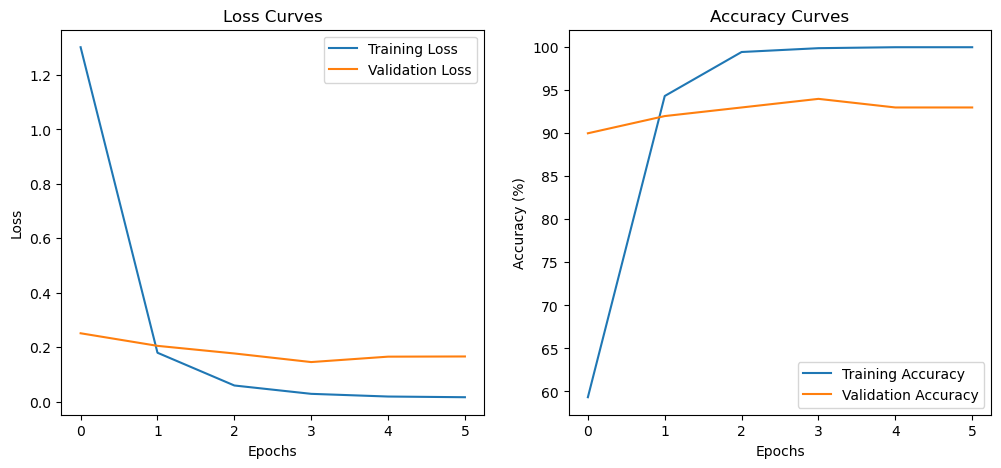

In [44]:
# Evaluate the model on the test set
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
  for inputs, labels in tqdm(test_loader, desc='Testing'):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs).logits
    loss = criterion(outputs, labels)
    test_loss += loss.item()

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Plotting the training and validation loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


In [45]:
# # Optional: Print layer training status
# for name, param in model.named_parameters():
#   status = 'Trainable' if param.requires_grad else 'Frozen'
#   print(f"{name}: {status}")

In [46]:
# from transformers import AdamW

# # Collect trainable parameters
# trainable_parameters = [p for p in model.parameters() if p.requires_grad]

# optimizer = AdamW(trainable_parameters, lr=2e-5, weight_decay=0.01)


In [47]:
# from transformers import get_linear_schedule_with_warmup

# num_epochs = 10
# total_steps = len(train_loader) * num_epochs
# warmup_steps = int(0.1 * total_steps)

# scheduler = get_linear_schedule_with_warmup(
#   optimizer,
#   num_warmup_steps=warmup_steps,
#   num_training_steps=total_steps
# )

In [48]:
# criterion = nn.CrossEntropyLoss()

## Task 2d

In [49]:
# import numpy as np

# # Initialize lists to store loss and accuracy
# train_losses = []
# val_losses = []
# train_accuracies = []
# val_accuracies = []

# for epoch in range(num_epochs):
#   # Training phase
#   model.train()
#   running_loss = 0.0
#   correct_train = 0
#   total_train = 0

#   for batch in train_loader:
#     inputs, labels = batch
#     inputs = inputs.to(device)
#     labels = labels.to(device)

#     optimizer.zero_grad()
#     outputs = model(inputs).logits
#     loss = criterion(outputs, labels)
#     loss.backward()
#     optimizer.step()
#     scheduler.step()

#     running_loss += loss.item()
#     _, preds = torch.max(outputs, 1)
#     correct_train += (preds == labels).sum().item()
#     total_train += labels.size(0)

#   avg_train_loss = running_loss / len(train_loader)
#   train_accuracy = correct_train / total_train
#   train_losses.append(avg_train_loss)
#   train_accuracies.append(train_accuracy)

#   # Validation phase
#   model.eval()
#   val_running_loss = 0.0
#   correct_val = 0
#   total_val = 0

#   with torch.no_grad():
#     for batch in val_loader:
#       inputs, labels = batch
#       inputs = inputs.to(device)
#       labels = labels.to(device)

#       outputs = model(inputs).logits
#       loss = criterion(outputs, labels)

#       val_running_loss += loss.item()
#       _, preds = torch.max(outputs, 1)
#       correct_val += (preds == labels).sum().item()
#       total_val += labels.size(0)

#   avg_val_loss = val_running_loss / len(val_loader)
#   val_accuracy = correct_val / total_val
#   val_losses.append(avg_val_loss)
#   val_accuracies.append(val_accuracy)

#   # Print statistics
#   print(f'Epoch [{epoch+1}/{num_epochs}]')
#   print(f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%')
#   print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%\n')
